In [1]:
from io import StringIO
import pandas as pd

class SurveyFile:
    def __init__(self, path):
        self.path = path
        self.metadata, self.details, self.instrument = self.read(path)
        self.df = pd.read_csv(StringIO(self.details), skiprows=1)
        self.df.index = self.df['Source Well']
    def read(self, path):
        with open(path) as f:
            data=f.read()
        return data.split('\n\n')[:3] # last item is empty
    
class TransferFile:
    def __init__(self, path):
        self.path = path
        self.metadata, _exceptions, _details, self.instrument = self.read(path)
        self.exceptions =  pd.read_csv(StringIO(_exceptions), skiprows=1)
        self.details =  pd.read_csv(StringIO(_details), skiprows=1)
    def read(self, path):
        with open(path) as f:
            data=f.read()
        return data.split('\n\n')[:4]
    
plateReaderFiles = sorted('''00-data/platereader/2022-02-28-s48-r1-4-blank.csv.CSV
00-data/platereader/2022-02-28-s48-r1-4-prot-cold.csv.CSV
00-data/platereader/2022-02-28-s48-r1-4-prot.csv.CSV'''.split('\n'))

echoFiles = sorted('''00-data/echo-reports/2022-02-28-00-echo-protocol.epr
00-data/echo-reports/2022-02-28/E5XX-1564_Survey_Source[1](UnknownBarCode).csv
00-data/echo-reports/2022-02-28/E5XX-1564_Transfer_1646040315_Exceptions.csv
00-data/echo-reports/2022-02-28/E5XX-1564_Survey_Source[1](UnknownBarCode).txt
00-data/echo-reports/2022-02-28/E5XX-1564_Transfer_1646040315.txt
00-data/echo-reports/2022-02-28/E5XX-1564_Survey_Source[1](UnknownBarCode)-01.csv
00-data/echo-reports/2022-02-28/E5XX-1564_Transfer_1646039578.csv
00-data/echo-reports/2022-02-28/E5XX-1564_Transfer_1646039578.txt
00-data/echo-reports/2022-02-28/E5XX-1564_Transfer_1646040315.csv
00-data/echo-reports/2022-02-28/E5XX-1564_Transfer_1646040315_Exceptions.txt
00-data/echo-reports/2022-02-28/E5XX-1564_Survey_Source[1](UnknownBarCode)-01.txt
00-data/echo-reports/2022-02-28/E5XX-1564_Transfer_1646039578_Exceptions.txt
00-data/echo-reports/2022-02-28/E5XX-1564_Transfer_1646039578_Exceptions.csv'''.split('\n'))

echoTransfers = [i for i in echoFiles if 'Transfer' in i]
echoSurveys = [i for i in echoFiles if 'Survey' in i]

In [2]:
import re
import plates
import matplotlib.pyplot as plt
plt.style.use('dark_background')

regex = lambda s : re.search('/([0-9a-zA-Z-]+)\.', s)
fname = lambda s : regex(s).group()[1:-1] if regex(s) is not None else None

data = {fname(i):plates.Plate(i) for i in plateReaderFiles}

for i in data:
    print(f'{i} : {data[i].meta}')

2022-02-28-s48-r1-4-blank : {'date': '28/02/2022', 'time': '12:12:30', 'protocol': 'scan', 'plateID': 'actually the blank,'}
2022-02-28-s48-r1-4-prot-cold : {'date': '28/02/2022', 'time': '12:21:58', 'protocol': 'scan', 'plateID': 'prot-cold,'}
2022-02-28-s48-r1-4-prot : {'date': '28/02/2022', 'time': '11:55:13', 'protocol': 'scan', 'plateID': 'blank,'}


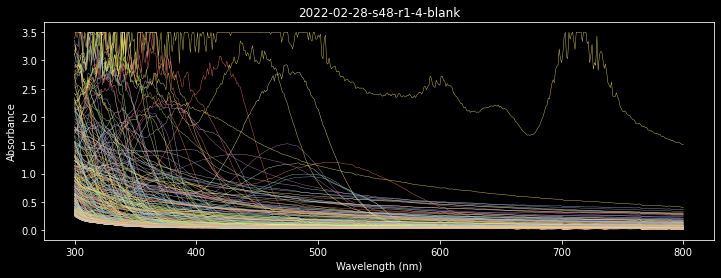

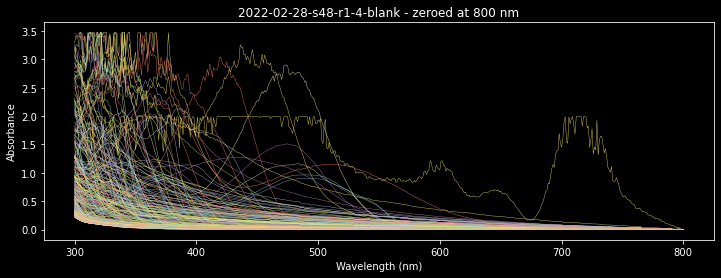

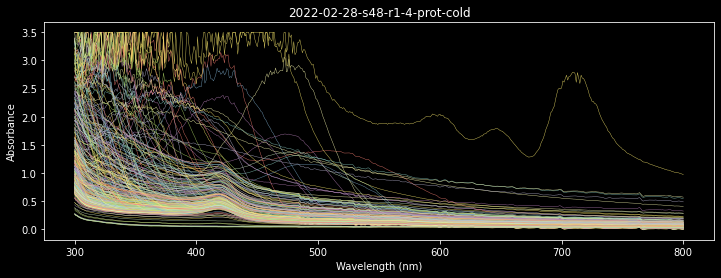

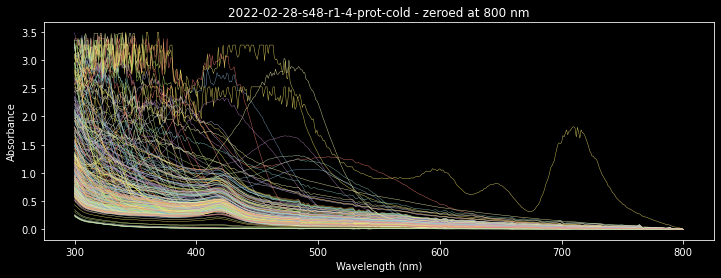

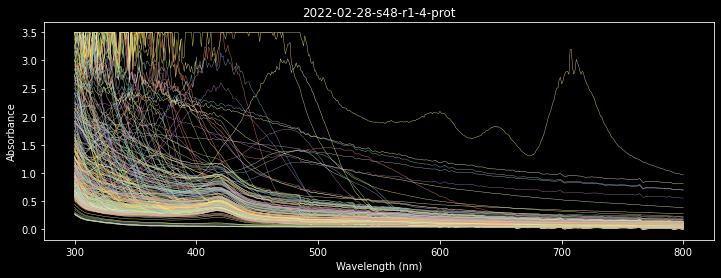

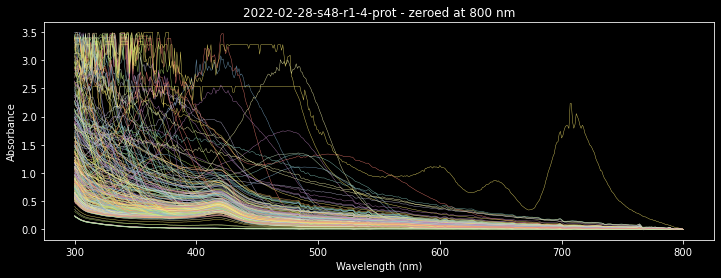

In [3]:
def plot(df, title=''):
    plt.figure(figsize=(12,4))
    for j in df.index:
        plt.plot(df.loc[j,:],lw=0.4, alpha=0.9)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absorbance')
    plt.title(title)
    plt.show()
    

zero800 = lambda df : df.sub(df.loc[:,800], axis=0)

for i in data:
     plot(data[i].df, i)
     plot(zero800(data[i].df), f'{i} - zeroed at 800 nm')

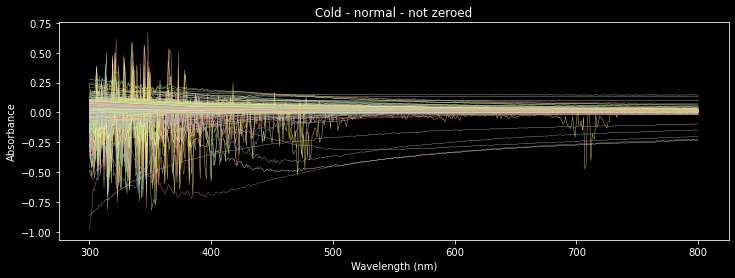

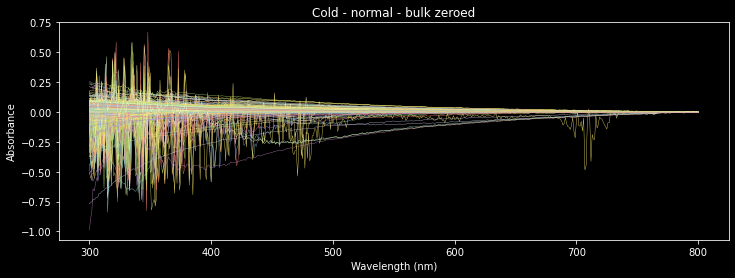

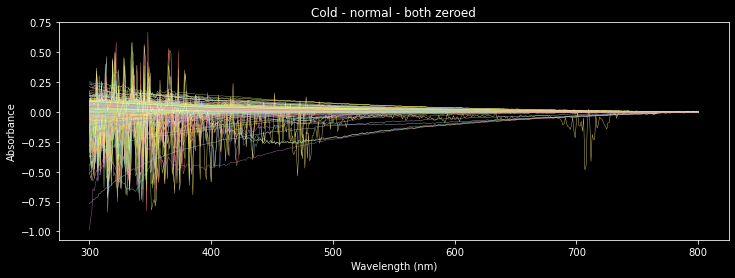

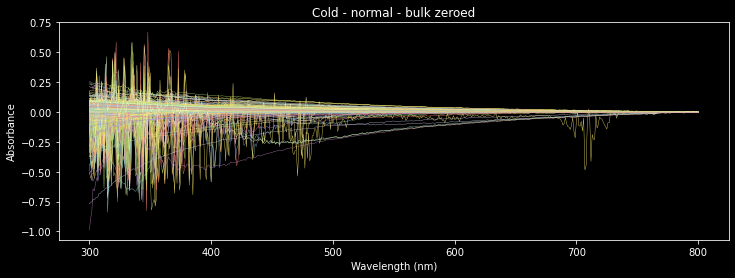

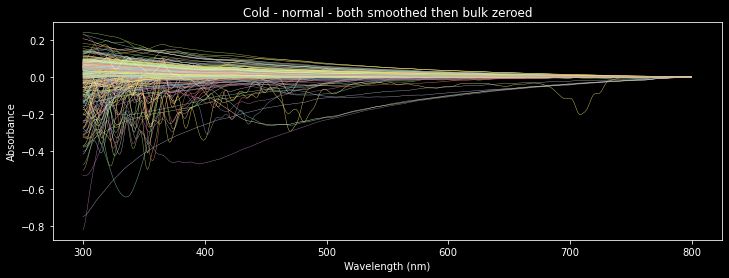

In [15]:
from scipy.ndimage import gaussian_filter1d
#smooth = plates.uv384.smooth
def smooth(data, sigma=3):
    normData = gaussian_filter1d(data, sigma, axis=1)
    return pd.DataFrame(normData, index = data.index, columns = data.columns)

plot(data['2022-02-28-s48-r1-4-prot-cold'].df - \
     data['2022-02-28-s48-r1-4-prot'].df, 
     'Cold - normal - not zeroed')
plot(zero800(data['2022-02-28-s48-r1-4-prot-cold'].df - \
             data['2022-02-28-s48-r1-4-prot'].df), 
     'Cold - normal - bulk zeroed')
plot(zero800(data['2022-02-28-s48-r1-4-prot-cold'].df) - \
     zero800(data['2022-02-28-s48-r1-4-prot'].df), 
     'Cold - normal - both zeroed')
plot(zero800(data['2022-02-28-s48-r1-4-prot-cold'].df - \
             data['2022-02-28-s48-r1-4-prot'].df), 
     'Cold - normal - bulk zeroed')
plot(zero800(smooth(data['2022-02-28-s48-r1-4-prot-cold'].df) - \
             smooth(data['2022-02-28-s48-r1-4-prot'].df)), 
     'Cold - normal - both smoothed then bulk zeroed')

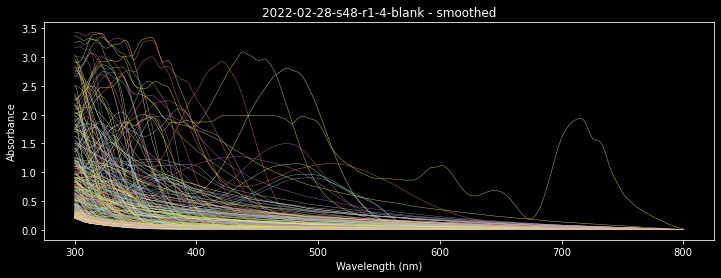

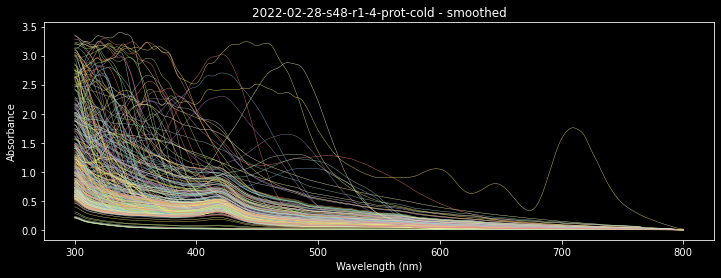

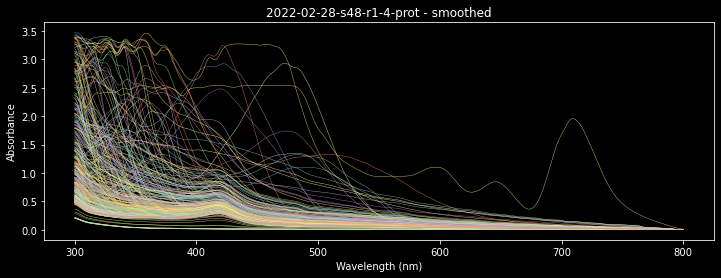

In [5]:
for i in data:
    plot(smooth(zero800(data[i].df)),f'{i} - smoothed')

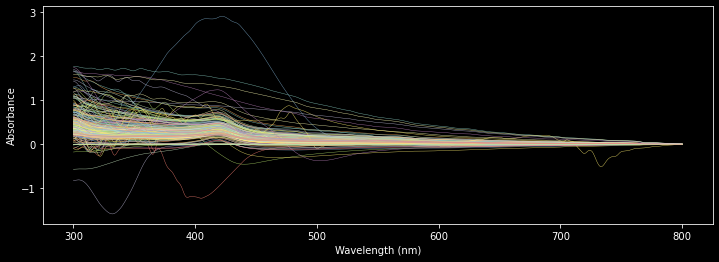

In [16]:
test = data['2022-02-28-s48-r1-4-prot']
ctrl = data['2022-02-28-s48-r1-4-blank']
x = smooth(zero800(test.df)) - smooth(zero800(ctrl.df), sigma=2) 
plot(x)

In [7]:
tx0 = TransferFile('00-data/echo-reports/2022-02-28/E5XX-1564_Transfer_1646039578.csv')
tx1 = TransferFile('00-data/echo-reports/2022-02-28/E5XX-1564_Transfer_1646040315.csv')
print('tx0')
print(tx0.metadata)
print('-'*32)
print('tx1')
print(tx1.metadata)

tx0
Run ID,1646039578
Run Date/Time,2022-02-28 09:12:36
Application Name,Labcyte Echo Plate Reformat
Application Version,1.6.4
Protocol Name,2022-02-28-00-echo-protocol.epr
User Name,Lab
--------------------------------
tx1
Run ID,1646040315
Run Date/Time,2022-02-28 09:24:53
Application Name,Labcyte Echo Plate Reformat
Application Version,1.6.4
Protocol Name,2022-02-28-00-echo-protocol.epr
User Name,Lab


### Filenames are in unix time
But there's a ~20 second gap between them and the run date time.

In [8]:
import datetime
print(datetime.datetime.fromtimestamp(1646039578))
print(datetime.datetime.fromtimestamp(1646040315))

2022-02-28 09:12:58
2022-02-28 09:25:15


In [9]:
tx0_wells = sorted(tx0.exceptions['Destination Well'])
tx1_wells = sorted(tx1.exceptions['Destination Well'])
print(tx0_wells)
print(len(tx0_wells))
print(tx1_wells)
print(len(tx1_wells))
len(set(tx0_wells + tx1_wells))

['A21', 'A23', 'A24', 'B11', 'B23', 'B24', 'C23', 'C24', 'C3', 'D23', 'D24', 'E23', 'E24', 'F20', 'F23', 'F24', 'G23', 'G24', 'G3', 'H23', 'H24', 'I23', 'I24', 'J23', 'J24', 'K23', 'K24', 'L23', 'L24', 'M15', 'M23', 'M24', 'N23', 'N24', 'O23', 'O24', 'P23', 'P24']
38
['A19', 'A2', 'A21', 'A23', 'A24', 'B11', 'B23', 'B24', 'C23', 'C24', 'C3', 'D23', 'D24', 'E23', 'E24', 'F20', 'F23', 'F24', 'G23', 'G24', 'G3', 'H23', 'H24', 'I23', 'I24', 'J23', 'J24', 'K23', 'K24', 'L23', 'L24', 'L5', 'M15', 'M23', 'M24', 'N23', 'N24', 'O23', 'O24', 'P23', 'P24']
41


41

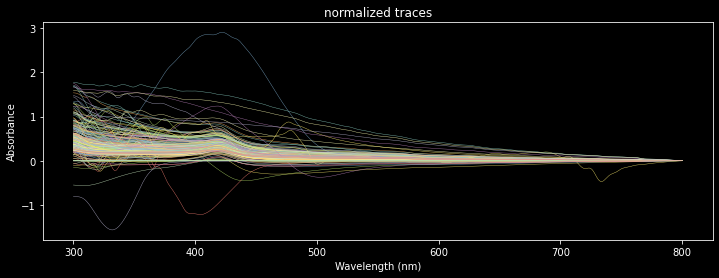

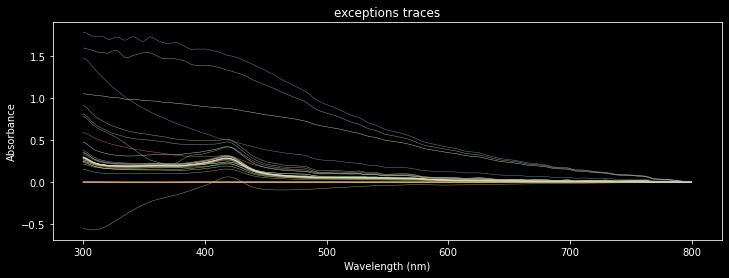

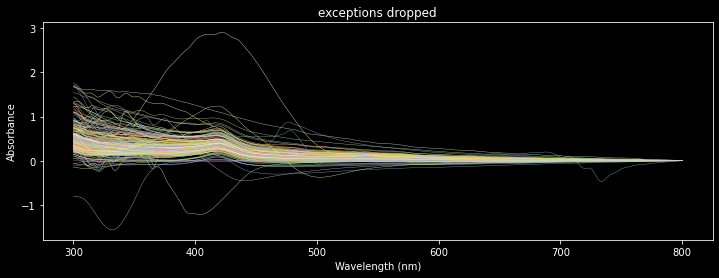

In [10]:
plot(x, 'normalized traces')
plot(x.loc[list(set(tx0_wells + tx1_wells)),:], 'exceptions traces')
plot(x.drop(list(set(tx0_wells + tx1_wells))), 'exceptions dropped')

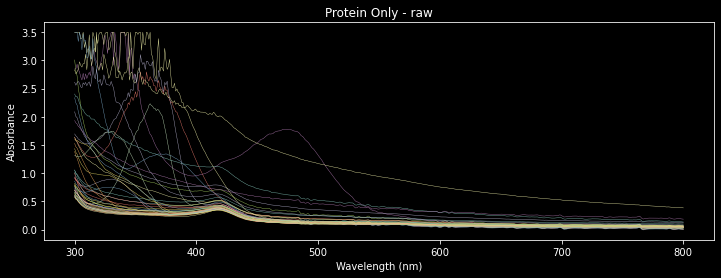

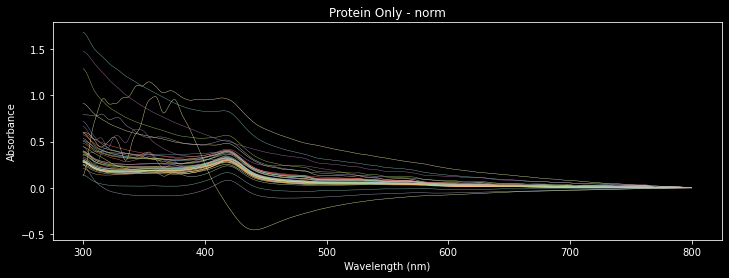

In [11]:
protein_only_wells = [f'{i}{j}' for i in ['P','O'] for j in range(1,25)]
plot(test.df.loc[protein_only_wells,:], 'Protein Only - raw')
plot(x.loc[protein_only_wells,:], 'Protein Only - norm')

In [17]:
ls

00-analysis.ipynb  00-data.tar.gz                00-labNotes.ipynb
00-data/           00-design-lab-notes-01.ipynb
